# Groupe non officiel 1
# Livrable 1 - Classification binaire

|Auteur|Centre|
|---|---|
|DIMEGLIO Nicolas|Aix-en-Provence|
|ROMANO Sébastien|Aix-en-Provence|
|SIXDENIER Alexandre|Aix-en-Provence|
|VESSERON Alexandre|Aix-en-Provence|

# Rappel du sujet
L'entreprise voulant automatiser la sélection de photos pour l'annotations, le but est de fournir une méthode de classification binaire afin de filtrer les images qui ne sont pas des photos du dataset de départ. Pour ce faire nous allons nous appuyer sur l'architecture des réseau de neurones, ainsi que l'analyse des résultats obtenus.
Toutes les parties doivent être détaillée dans le notebook :
    - les paramètre du réseau,
    - la fonction de perte ainsi que l'algorithme d'optimisation utilisé pour l’entraînement.

# Analyse à effectuer
- Graphique contenant l'évolution de l'erreur d’entraînement ainsi que de l'erreur de test
- Graphique l'évolution de l'accuracy pour ces deux datasets.

- L'analyse de ces résultats, notamment le compromis entre biais et variance (ou sur-apprentissage et sous-apprentissage).

- Une description des méthodes potentiellement utilisables pour améliorer les compromis biais/variance : technique de régularisation, drop out, early-stopping, ...


# Import des différentes bibliothèques

In [1]:
import pathlib
import zipfile
import os
import PIL
import subset as subset
import tensorflow as tf
from PIL import Image as Image
from keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models

# Téléchargement des données et dezippage

In [2]:
path_to_zip_file = "Dataset projet" #"C:\\Users\\nicos\\PycharmProjects\\Projet_DataScience_A5\\Dataset projet"
directory_to_extract_to = "D:\\DOCUMENT\\ecole\\cesi\\annee 5\\Projet_DataScience_A5\\Dataset"#"C:\\Users\\nicos\\PycharmProjects\\Projet_DataScience_A5\\Dataset"
data_dir = directory_to_extract_to

In [81]:
for directory in os.listdir(path_to_zip_file):
    print(directory)
    with zipfile.ZipFile(path_to_zip_file + "\\" + directory, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

Dataset Livrable 1 - Painting.zip
Dataset Livrable 1 - Photo.zip
Dataset Livrable 1 - Schematics.zip
Dataset Livrable 1 - Sketch.zip
Dataset Livrable 1 - Text.zip


In [ ]:
for directory in os.listdir(directory_to_extract_to):
    print(directory_to_extract_to + "\\" + directory)
    for file in os.listdir(directory_to_extract_to + "\\" + directory):
        image = None
        try:
            image = Image.open(directory_to_extract_to + "\\" + directory + "\\" + file)
            data = list(image.getdata())
            image_without_exif = Image.new(image.mode, image.size)
            image_without_exif.putdata(data)
            image_without_exif.save(directory_to_extract_to + "\\" + directory + "\\" + file)
        except:
            print(directory_to_extract_to + "\\" + directory + "\\" + file)
            image.close()
            os.remove(directory_to_extract_to + "\\" + directory + "\\" + file)
            pass

D:\DOCUMENT\ecole\cesi\annee 5\Projet_DataScience_A5\Dataset\Painting


# Récupération des données

In [3]:
data_dir = pathlib.Path(data_dir)

Pour commencer, nous devons spécifier quelques paramètres pour l'apprentissage:
<ul>
    <li>La longueur et la largeur des images. </li>
    <li>La taille du batch.</li>
</ul>

In [4]:
image_h = 180
image_w = 180
batch_s = 32

# Préparation des données

Nous devons partager le jeu de données en jeu d'entrainement et de validation.

In [5]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split= 0.20,
  subset = 'training',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode='rgb',
  label_mode='int',
  labels="inferred"
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split= 0.20,
  subset = 'validation',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode='rgb',
  label_mode='int',
  labels="inferred"
)

Found 41395 files belonging to 5 classes.
Using 33116 files for training.
Found 41395 files belonging to 5 classes.
Using 8279 files for validation.


La sortie nous permet de voir le nombres de fichier total et de savoir de combien de fichier sont constitués nos jeux d'entrainement et de test.

# 2. Exploration et visualisation des données
Commençons, tout d'abord par afficher le nom des différentes classes de nos données.

In [6]:
class_names =  train_set.class_names #A COMPLETER
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


Afin de vérifier la bonne récupération des données, nous allons afficher quelques images ranndom issues de tout nos dossiers.

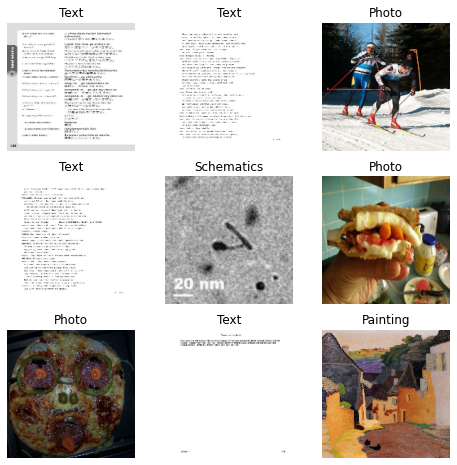

In [7]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

On voudrait aussi connaître la taille des données, afin de gérer les performances du modèle.

In [8]:
images, labels = next(iter(train_set))
print(images.shape)
print(labels.shape)

(32, 180, 180, 3)
(32,)


# 3. Configuration de l'environnement pour l'entrainement

- `Dataset.cache()` : Cette fonction sert à forcer le maintien des données en cache dans la mémoire. Vu que le réseau de neurones fait plusieurs passes (qu'on nomme _époque_ ou _epoch_ en anglais) sur les données durant l'apprentissage, cette fonction permet de ne pas avoir à recharger les images à chaque fois.
- `Dataset.prefetch()` : Cette fonction permet de faire le prétraitement de l'élément courant du jeu de données (par exemple le batch suivant) en même temps que l'entrainement/évaluation du batch courant par le modèle. Dans un environnement multi-processeurs ou multi-cœur, c'est un gain de temps non négligeable.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_set = train_set.cache().shuffle(5).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)


# 4. La normalisation

# 5. Le modèle de réseau de neurones convolutif (CNN)

On va par la suite créer un modèle vide à l'aide de la fonction Sequential de tensorflow.
Par la suite nous rajouterons la classification d'image.
Pour être sur que notre modèle soit bien entrainer, nous allons utiliser des techniques de régularisation.

In [10]:
num_classes = 5 # Nombre de classes et donc aussi nombre de neurones dans la dernière couche
#model = models.Sequential()
#model = tf.keras.layers.Dropout(
#    rate=0.2, noise_shape=None, seed=42,
#)
# Résumé du modèle
model = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(
        mode="horizontal_and_vertical",seed=42,input_shape=(image_h, image_w, 3)),
    layers.experimental.preprocessing.RandomRotation(
        factor = (-0.2, 0.3),
        fill_mode="reflect",
        interpolation="bilinear",
        seed=42,
        fill_value=0.0,
    ),
    layers.experimental.preprocessing.RandomZoom(
        height_factor= (0.2, 0.3),
        width_factor=None,
        fill_mode="reflect",
        interpolation="bilinear",
        seed=42,
        fill_value=0.0,
    ),
  tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, offset=0),
  tf.keras.layers.Conv2D(16, [3,3], activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, [3,3], activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, [3,3], activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.2, noise_shape=None, seed=42),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

On compile le modèle.

In [11]:
model.compile(optimizer = 'adam',  #A COMPLETER
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Après avoir compiler le model, nous allons entrainer notre réseau de neuronne avec les données normalisées.

In [ ]:
epochs=10

history = model.fit(train_set,validation_data = test_set,epochs=epochs)
model.summary()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/10
 471/1035 [============>.................] - ETA: 3:14 - loss: 0.7706 - accuracy: 0.6659

# Supression des données à tester

In [29]:
#for directory in os.listdir(path_to_zip_file):
#   with zipfile.ZipFile(path_to_zip_file + "\\" + directory, 'r') as zip_ref:
#            os.remove(directory)


D:\DOCUMENT\ecole\cesi\annee 5\Projet_DataScience_A5\Dataset\Painting
D:\DOCUMENT\ecole\cesi\annee 5\Projet_DataScience_A5\Dataset\Painting\painting_01794.jpg
D:\DOCUMENT\ecole\cesi\annee 5\Projet_DataScience_A5\Dataset\Painting\painting_04963.jpg
D:\DOCUMENT\ecole\cesi\annee 5\Projet_DataScience_A5\Dataset\Painting\painting_05169.jpg
D:\DOCUMENT\ecole\cesi\annee 5\Projet_DataScience_A5\Dataset\Painting\painting_06433.jpg
D:\DOCUMENT\ecole\cesi\annee 5\Projet_DataScience_A5\Dataset\Painting\painting_06533.jpg
D:\DOCUMENT\ecole\cesi\annee 5\Projet_DataScience_A5\Dataset\Painting\painting_07549.jpg
D:\DOCUMENT\ecole\cesi\annee 5\Projet_DataScience_A5\Dataset\Painting\painting_08128.jpg
D:\DOCUMENT\ecole\cesi\annee 5\Projet_DataScience_A5\Dataset\Painting\painting_08211.jpg
D:\DOCUMENT\ecole\cesi\annee 5\Projet_DataScience_A5\Dataset\Painting\painting_08502.jpg
D:\DOCUMENT\ecole\cesi\annee 5\Projet_DataScience_A5\Dataset\Painting\painting_09900.jpg
D:\DOCUMENT\ecole\cesi\annee 5\Projet_Da